In [63]:
from configparser import ConfigParser
import cmasher as cmr
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from matplotlib import rc
import matplotlib.ticker as mticker
from astropy.io import fits

import spectral_analysis
import isothermal_dispersion_equations
import magnetic_field_stats_functions

plt.style.use("classic")

###############################################################################
################################### Plotting ##################################
###############################################################################

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font
# of your choice!)
# rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
# These parameters can also be put into the style or matplotlibrc.
# This is the dynamic approach of changing parameters.
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times New Roman",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 16,
    "font.size": 16,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "legend.frameon": True,
    "legend.framealpha": 0.8,
    "axes.formatter.use_mathtext": True,
    # "figure.dpi": 300,
    # "figure.autolayout": True,
    "lines.linewidth": 2,
    "ytick.minor.visible": True,
    "xtick.minor.visible": True,
    "figure.facecolor": "white",
    # "savefig.bbox": "tight",
    "savefig.dpi": 300,
    "pcolor.shading": "auto",
    "figure.facecolor": "white"
}
matplotlib.rcParams.update(tex_fonts)

# Set the font used for MathJax - more on this later
rc("mathtext", **{"default": "regular"})

In [64]:

###############################################################################
############################### Directories ###################################
###############################################################################

# Config file holds information for each dataset
config_object = ConfigParser()
config_object.read("AGWs_config.ini")

# Dataset -- 25Apr2019, 26Apr2019, 06May2019, 08May2019, 09May2019
date = "04252019"
written_date = "25Apr2019"

# Grab the location and plate scale information associated with chosen date
date_image_information = config_object[date]

# Data directory
data_dir = "/media/oana/Data1/AGWs/" + written_date + "/Data/" 

# Model atmosphere of the Sun
model_atm_data = ascii.read("/media/oana/Data1/AGWs/IBISdata/CSM_A.dat")

# Determine which file type to grab -- intensity versus velocity
fname_type_dict = {0: "int", 1: "vel"}
fname_type = fname_type_dict.get(1)

# Choose spectral diagnostics -- HMIcont, HMIdop, fe7090, k7699, fe5434, ca8542 -- all [km/s]
# HMIcont -- need to divide by 1e-4 to get [km/s]
spectral_line_higher = "k7699" # line that forms "higher" in the atmosphere
spectral_line_lower = "fe7090" # line that forms "lower" in the atmosphere

# File names
magnetogram_file = data_dir + "%s.HMImag.ibis.aligned.fits"%(written_date)
lower_line_file = data_dir + "%s.ibis.to.hmi.%s.%s.fits"%(written_date,fname_type,spectral_line_lower)
higher_line_file = data_dir + "%s.ibis.to.hmi.%s.%s.fits"%(written_date,fname_type,spectral_line_higher)

print("Reading in the following FITs files:")
print(lower_line_file,"\n", higher_line_file)
print("\n")

Reading in the following FITs files:
/media/oana/Data1/AGWs/25Apr2019/Data/25Apr2019.ibis.to.hmi.vel.fe7090.fits 
 /media/oana/Data1/AGWs/25Apr2019/Data/25Apr2019.ibis.to.hmi.vel.k7699.fits




In [65]:
###############################################################################
############################## Read in Data ###################################
###############################################################################

# Whatever detrending is chosen, need to make sure that the datacubes are all the same size
# i.e, subtracting the mean, calculating the n-th difference
# Note: datacubes are transposed to [Y,X,T] ~ to accomodate sunpy.maps if used

# HMI Magnetogram
magnetogram = fits.open(magnetogram_file)[0].data
magnetogram = np.transpose(magnetogram, (1, 2, 0))
magnetogram = magnetogram/10 # Need to divide by 10 for Gauss units
# magnetogram = magnetogram[:,:,:839]

# Spectral Line 1
lower_line = fits.open(lower_line_file)[0].data
lower_line = np.transpose(lower_line, (1, 2, 0))
# lower_line = np.diff(lower_line,axis=-1)
lower_line -= np.mean(lower_line)

# Spectral Line 2
higher_line = fits.open(higher_line_file)[0].data
higher_line = np.transpose(higher_line, (1, 2, 0))
higher_line -= np.mean(higher_line)
# higher_line = np.diff(higher_line,axis=-1)

print("IBIS 1 cube shape: ",(lower_line.shape))
print("IBIS 2 cube shape: ",(higher_line.shape))
print("Magnetogram cube shape: ",(magnetogram.shape))


IBIS 1 cube shape:  (160, 160, 840)
IBIS 2 cube shape:  (160, 160, 840)
Magnetogram cube shape:  (160, 160, 840)


In [66]:

###############################################################################
############################ Grid Information #################################
###############################################################################

distance = 147.1e6  # Earth-Sun distance in km
convert_arcseconds_to_Mm = spectral_analysis.conversion_arcseconds_to_Mm(distance) # scaling for arcsec into Mm

# Spatial sampling [arcsec/pixel]
dx = float(date_image_information["dx"])

# Cadence of data [s]
dt = float(date_image_information["dt"])  

# Nyquist wavenumber [1/arcsec]
kx = np.pi / dx

print("Nyquist wavnumber is %s 1/arcsec" % kx)
print("Nyquist wavnumber is %s 1/Mm" % (kx / convert_arcseconds_to_Mm))
print("Nyquist wavnumber is %s 1/km" % ((kx / convert_arcseconds_to_Mm) / 1000))

# Nyquist frequency/angular frequency [rad/s]
omega = np.pi / dt

# Nyquist frequency/cyclic frequency [Hz]
v = omega / (2 * np.pi)
frq = v * 1000  # [mHz]
print("Nyquist frequency is %s mHz" % frq)

###############################################################################
############################ Define Meshgrid ##################################
###############################################################################

# Starting time
start = 0
# Duration of data -- length of time series
end_time = higher_line.shape[-1]
# Spatial length of data -- x and y... Ideally should be the same value (crop data cube if not)
end_space = higher_line.shape[0]

# Mid time and space
mid_time = end_time // 2
mid_space = end_space // 2

print("The middle time is %s and the end time is %s " % (mid_time, end_time))

# Field of view [arcsec]
fov = dx * end_space 
print("FOV is %s arcseconds" % (fov))

# Horizontal wavenumber 
horizontal_array = np.linspace(0.0, kx, int(mid_space), endpoint=True)  # [1/arcsec]
kx_km = horizontal_array / convert_arcseconds_to_Mm / 1000  # [1/km]

# Field of view array
arcsecond_length_array = np.linspace(0.0, fov, int(end_space), endpoint=True)
# Meshgrid for field of view (if needed)
arcx, arcy = np.meshgrid(arcsecond_length_array, arcsecond_length_array)

print("The FOV meshgrid has the following shape: ", arcx.shape)

# Frequency [mHz]
freq_array = np.linspace(0.0, frq, int(mid_time), endpoint=True)
print("The three first frequencies are ", freq_array[0:4])
print("The length of the frequency array is", len(freq_array))

# Meshgrid for data
NU, KH = np.meshgrid(freq_array, horizontal_array)
print("The meshgrid has the following shape: ", KH.shape)

# Compute grid to azimuthally average over
x = np.linspace(-mid_space, mid_space - 1, end_space)  # size of kx
y = np.linspace(-mid_space, mid_space - 1, end_space)  # sixe of ky
X, Y = np.meshgrid(x, y)
radial_dist = np.hypot(X, Y)
print(
    "The shape of the grid to compute the azimuthal averaging over is ",
    radial_dist.shape,
)



Nyquist wavnumber is 5.235987755982989 1/arcsec
Nyquist wavnumber is 7.341944255608431 1/Mm
Nyquist wavnumber is 0.0073419442556084315 1/km
Nyquist frequency is 42.08754208754208 mHz
The middle time is 420 and the end time is 840 
FOV is 96.0 arcseconds
The FOV meshgrid has the following shape:  (160, 160)
The three first frequencies are  [0.         0.10044759 0.20089519 0.30134278]
The length of the frequency array is 420
The meshgrid has the following shape:  (80, 420)
The shape of the grid to compute the azimuthal averaging over is  (160, 160)


In [67]:

###############################################################################
############################# Dispersion Equations ############################
###############################################################################

cs_cgs = model_atm_data["col6"]  # [cm/s]
grav = model_atm_data["col2"]  # [cm/s²]
height = model_atm_data["col1"]  # [Mm]
density_cgs = model_atm_data["col4"]  # [g/cm^3]
dRho_dz = model_atm_data["col5"]  # ?? should be in cgs...
dP_dz = model_atm_data["col3"]  # ?? should be in cgs...
density_Mm = density_cgs / (1e-8) ** 3  # [g/Mm^3]
gravity_cgs = 27400  # [cm/s²]
gravity_Mm = 274 / 1e6  # [Mm/s²]
gravity_km = 0.274  # [km/s²]
cs_Mm = cs_cgs * 1e-8  # [Mm/s]
cs_km = cs_cgs * 1e-5  # [km/s]

height_index = 1005  # Height of 0.25 Mm or 250 km

# Fundamental mode (f-mode) curve; w = sqrt(k_h*g)
surface_fmode = isothermal_dispersion_equations.surface_fmodes(
    gravity_km, kx_km
)  # angular frequency [Hz]

# Lamb frequency; w = c_s*k_h
lamb_curve = isothermal_dispersion_equations.lamb_frequency(
    cs_km[height_index], kx_km
)  # angular frequency [Hz]

# Density Scale Height (cm)
density_scale_height_value = isothermal_dispersion_equations.densityscaleheight(
    dRho_dz[height_index], density_cgs[height_index]
)

# acoustic cut-off frequency squared
acoustic_cutoff_frequency_squared = (
    isothermal_dispersion_equations.acoustic_cutoff_frequency(
        cs_cgs[height_index], density_scale_height_value
    )
)  # angular frequency squared  [Hz^2]


Brunt_Vaisala_frequency_Squared_value = (
    isothermal_dispersion_equations.Brunt_Vaisala_frequency_Squared(
        gravity_cgs,
        dP_dz[height_index],
        cs_cgs[height_index],
        density_cgs[height_index],
        dRho_dz[height_index],
    )
)  # angular frequency squared [Hz^2]


# Solve the isothermal dispersion relation in the absence of a magnetic field

a = 1
b = -(acoustic_cutoff_frequency_squared + cs_km[height_index] ** 2 * kx_km**2)
c = Brunt_Vaisala_frequency_Squared_value * cs_km[height_index] ** 2 * kx_km**2


qval1, qval2 = isothermal_dispersion_equations.quadraticforumala(a, b, c)

In [68]:
###############################################################################
############################ Magnetogram Statistics ###########################
###############################################################################

# Take absolute value of the magnetogram
magmap = np.abs(magnetogram)

# Basic statistics
med_mag = np.median(magmap)
mean_mag = np.mean(magmap)
std_mag = np.std(magmap)

print("\n")
print("The median LOS magnetic field is %.2f G"%(med_mag))
print("The mean LOS magnetic field is %.2f G"%(mean_mag))
print("The std LOS magnetic field is %.2f G"%(std_mag))

print("\n")
print("Min B: %.2f G"%(magnetogram.min()))
print("Max B: %.2f G"%(magnetogram.max()))
print("\n")



The median LOS magnetic field is 4.20 G
The mean LOS magnetic field is 8.46 G
The std LOS magnetic field is 23.14 G


Min B: -738.60 G
Max B: 687.20 G




In [69]:

###############################################################################
################################## Masked Maps ################################
###############################################################################

# Choose magnetic field value
chosen_mag_val = med_mag

# Mask the magnetogram depending on the chosen_mag_val
# mag_map -- masked magnetogram larger than chosen_mag_val
# nonmag_map -- masked magnetogram smaller than chosen_mag_val
mag_map, nonmag_map = magnetic_field_stats_functions.masked_magnetic_maps(
    magnetogram, chosen_mag_val
)

# Mask the lower forming spectral diagnostic map [ < chosen_mag_val]
masked_lower_line_less_than_mag_val = (
    magnetic_field_stats_functions.masked_IBIS_cubes_based_on_masked_magnetogram(
        lower_line, mag_map
    )
)

# Mask the higher forming spectral diagnostic map [ < chosen_mag_val]
masked_higher_line_less_than_mag_val = (
    magnetic_field_stats_functions.masked_IBIS_cubes_based_on_masked_magnetogram(
        higher_line, mag_map
    )
)

# Mask the lower forming spectral diagnostic map [ > chosen_mag_val]
masked_lower_line_greater_than_mag_val = (
    magnetic_field_stats_functions.masked_IBIS_cubes_based_on_masked_magnetogram(
        lower_line, nonmag_map
    )
)

# Mask the higher forming spectral diagnostic map [ > chosen_mag_val]
masked_higher_line_greater_than_mag_val = (
    magnetic_field_stats_functions.masked_IBIS_cubes_based_on_masked_magnetogram(
        higher_line, nonmag_map
    )
)



# Double check masking
print("Checking Magnetogram Masking...")
print("\n")
print("Original magnetogram: (%s, %s)"%(magnetogram.min(),magnetogram.max()))
print("Masked magnetogram larger than chosen_mag_val: (%s, %s)"%(mag_map.min(),mag_map.max()))
print("Masked magnetogram smaller than chosen_mag_val: (%s, %s)"%(nonmag_map.min(),nonmag_map.max()))
print("\n")
print("\n")
print("Checking Masked IBIS data products...")
print("\n")
print("Original lower forming spectral diagnostic: (%s, %s)"%(lower_line.min(),lower_line.max()))
print("Masked lower forming spectral diagnostic larger than chosen_mag_val: (%s, %s)"%(masked_lower_line_greater_than_mag_val.min(),masked_lower_line_greater_than_mag_val.max()))
print("Masked lower forming spectral diagnostic smaller than chosen_mag_val: (%s, %s)"%(masked_lower_line_less_than_mag_val.min(),masked_lower_line_less_than_mag_val.max()))
print("\n")
print("Original higher forming spectral diagnostic: (%s, %s)"%(higher_line.min(),higher_line.max()))
print("Masked higher forming spectral diagnostic larger than chosen_mag_val: (%s, %s)"%(masked_higher_line_greater_than_mag_val.min(),masked_higher_line_greater_than_mag_val.max()))
print("Masked higher forming spectral diagnostic smaller than chosen_mag_val: (%s, %s)"%(masked_higher_line_less_than_mag_val.min(),masked_higher_line_less_than_mag_val.max()))

Checking Magnetogram Masking...


Original magnetogram: (-738.6, 687.2)
Masked magnetogram larger than chosen_mag_val: (4.3, 738.6)
Masked magnetogram smaller than chosen_mag_val: (0.0, 4.2)




Checking Masked IBIS data products...


Original lower forming spectral diagnostic: (-2.1380053, 1.9956126)
Masked lower forming spectral diagnostic larger than chosen_mag_val: (-2.1380053, 1.7311994)
Masked lower forming spectral diagnostic smaller than chosen_mag_val: (-1.9753416, 1.9956126)


Original higher forming spectral diagnostic: (-6.4757257, 2.1221387)
Masked higher forming spectral diagnostic larger than chosen_mag_val: (-3.5880537, 2.1221387)
Masked higher forming spectral diagnostic smaller than chosen_mag_val: (-6.4757257, 1.9693477)


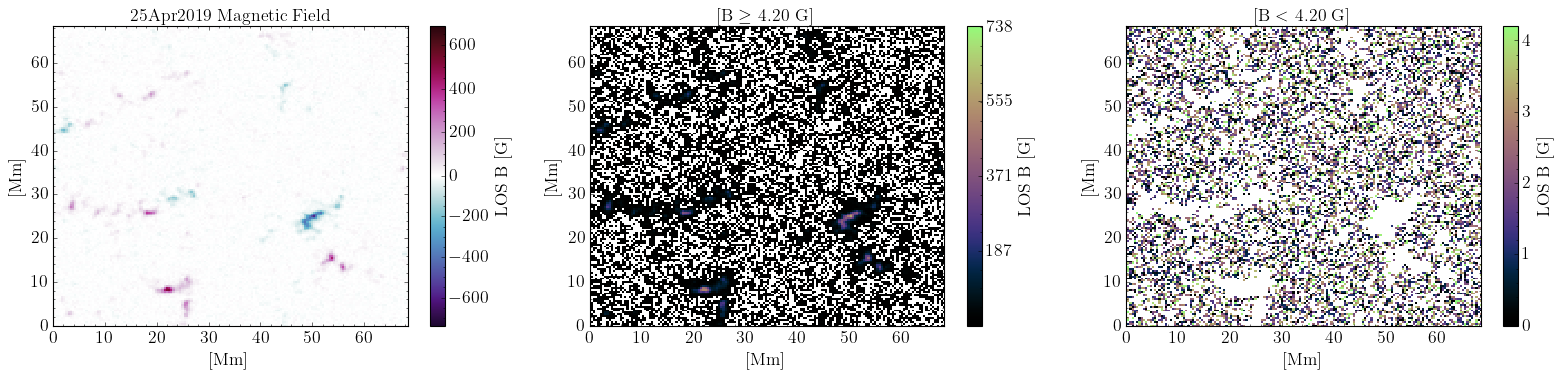

In [70]:
###############################################################################
########################### Plot Masked Magnetograms ##########################
###############################################################################

# Chosen frame
indx = 200

# cmap
chosen_cmap=cmr.lilac


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[20, 5])

im = ax1.pcolormesh(
    arcx * convert_arcseconds_to_Mm,
    arcy * convert_arcseconds_to_Mm,
    magnetogram[:, :, indx],
    cmap=cmr.viola,
    norm=mcolors.TwoSlopeNorm(vmin=int(magnetogram.min()), vcenter=0.0, vmax=int(magnetogram.max())),
    rasterized=True,
)

# ticks_mag = np.arange(magnetogram.min(), magnetogram.max(), 100, dtype=np.int64)


fig.colorbar(im, ax=ax1, label="LOS B [G]") #, ticks=ticks_mag)
ax1.set_title("%s Magnetic Field"%(written_date))
ax1.set_xlim(0, (arcx * convert_arcseconds_to_Mm).max())
ax1.set_ylim(0, (arcy * convert_arcseconds_to_Mm).max())
ax1.set_ylabel("[Mm]")
ax1.set_xlabel("[Mm]")


im = ax2.pcolormesh(
    arcx * convert_arcseconds_to_Mm,
    arcy * convert_arcseconds_to_Mm,
    mag_map[:, :, indx],
    cmap=chosen_cmap,
    vmin=mag_map.min(),
    vmax=mag_map.max(),
    rasterized=True,
)


ticks_mag = np.linspace(mag_map.min(), mag_map.max(), int(chosen_mag_val)+1, endpoint=True, dtype=np.int64)

fig.colorbar(im, ax=ax2, label="LOS B [G]", ticks=ticks_mag)
ax2.set_title(r"[B $\geq$ {:.2f} G]".format(chosen_mag_val))
ax2.set_xlim(0, (arcx * convert_arcseconds_to_Mm).max())
ax2.set_ylim(0, (arcy * convert_arcseconds_to_Mm).max())
ax2.set_ylabel("[Mm]")
ax2.set_xlabel("[Mm]")


im2 = ax3.pcolormesh(
    arcx * convert_arcseconds_to_Mm,
    arcy * convert_arcseconds_to_Mm,
    nonmag_map[:, :, indx],
    cmap=chosen_cmap,
    rasterized=True,
    vmin=nonmag_map.min(),
    vmax=nonmag_map.max(),
)

ticks_mag = np.linspace(nonmag_map.min(), nonmag_map.max(), int(chosen_mag_val)+1, endpoint=True, dtype=np.int64)

cbar = fig.colorbar(im2, ax=ax3, label="LOS B [G]", ticks=ticks_mag)
# cbar.locator = matplotlib.ticker.FixedLocator([0, 1, 2, 3, 4, 5.4])
# cbar.update_ticks()

ax3.set_title(r"[B $<$ {:.2f} G]".format(chosen_mag_val))
ax3.set_xlim(0, (arcx * convert_arcseconds_to_Mm).max())
ax3.set_ylim(0, (arcy * convert_arcseconds_to_Mm).max())

ax3.set_ylabel("[Mm]")
ax3.set_xlabel("[Mm]")
plt.tight_layout()
# fig.savefig("%s_masked_magnetograms.png"%(written_date), dpi=400, bbox_inches="tight")
plt.show()


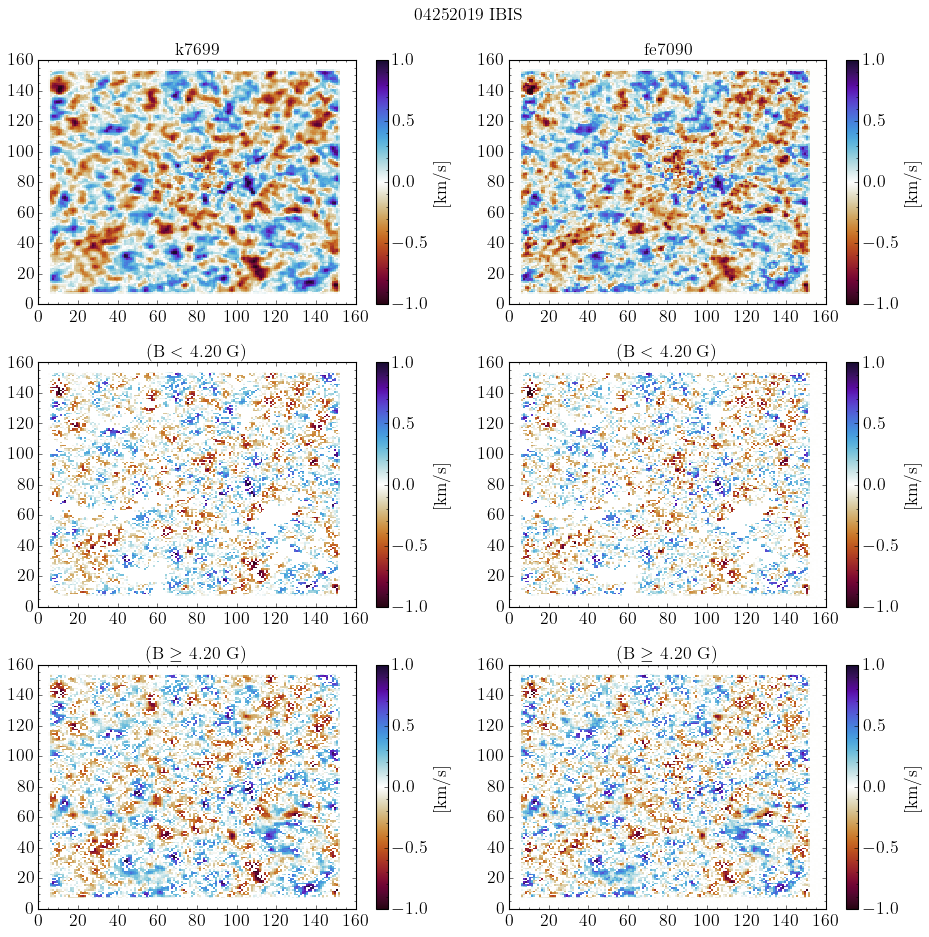

In [71]:

###############################################################################
############################ Plot Masked IBIS Maps ############################
###############################################################################

# normalizations for IBIS velocity maps... (doesn't apply for intensity maps)
vmin = -1
vmax = 1

# Time index
indx = 200

# colormap
chosen_cmap = cmr.fusion

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=[12, 12])

im = ax1.pcolormesh(
    higher_line[:, :, indx],
    cmap=chosen_cmap,
    rasterized=True,
    norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
)
cbar = fig.colorbar(im, ax=ax1, label="[km/s]")
cbar.ax.set_yscale("linear")


# ax1.set_xlim(0, 326)
# ax1.set_ylim(0, 326)
fig.suptitle(date + " IBIS")
ax1.set_title(spectral_line_higher)


im2 = ax2.pcolormesh(
    lower_line[:, :, indx],
    cmap=chosen_cmap,
    rasterized=True,
    norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
)
cbar = fig.colorbar(im2, ax=ax2, label="[km/s]")
cbar.ax.set_yscale("linear")
ax2.set_title(spectral_line_lower)


im3 = ax3.pcolormesh(
    masked_higher_line_greater_than_mag_val[:, :, indx],
    cmap=chosen_cmap,
    rasterized=True,
    norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
)
cbar = fig.colorbar(im3, ax=ax3, label="[km/s]")
cbar.ax.set_yscale("linear")
ax3.set_title(r"(B $<$ {:.2f} G)".format(chosen_mag_val))

im4 = ax4.pcolormesh(
    masked_lower_line_greater_than_mag_val[:, :, indx],
    cmap=chosen_cmap,
    rasterized=True,
    norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
)
fig.colorbar(im4, ax=ax4, label="[km/s]")
ax4.set_title(r"(B $<$ {:.2f} G)".format(chosen_mag_val))

im5 = ax5.pcolormesh(
    masked_higher_line_less_than_mag_val[:, :, indx],
    cmap=chosen_cmap,
    rasterized=True,
    norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
)
cbar = fig.colorbar(im5, ax=ax5, label="[km/s]")
cbar.ax.set_yscale("linear")
ax5.set_title(r"(B $\geq$ {:.2f} G)".format(chosen_mag_val))

im6 = ax6.pcolormesh(
    masked_lower_line_less_than_mag_val[:, :, indx],
    cmap=chosen_cmap,
    rasterized=True,
    norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
)

cbar = fig.colorbar(im6, ax=ax6, label="[km/s]")
cbar.ax.set_yscale("linear")
ax6.set_title(r"(B $\geq$ {:.2f} G)".format(chosen_mag_val))


plt.tight_layout()
# fig.savefig("%s_%s_%s_magnetic_field_IBIS_effects.png"%(spectral_line_higher,spectral_line_lower,fname_type), dpi=400, bbox_inches="tight")

plt.show()



In [74]:

###############################################################################
############################## Line Core Sampling #############################
###############################################################################

# Account for the line core sampling delay caused by the IBIS instrument
# Add value to the azimuthally averaged phase differences at the end
# HMIdop was aligned to Fe 7090 (select_phase_correction = np.zeros(phase_correction_7090_7699.shape))
# HMIdop then follows phase difference correction order of Fe 7090

phase_correction_8542_7090 = spectral_analysis.phase_difference_correction(
    omega, mid_time + 1, mid_space, float(date_image_information["dt_ca_fe7090"])
)

phase_correction_8542_7699 = spectral_analysis.phase_difference_correction(
    omega, mid_time + 1, mid_space, float(date_image_information["dt_ca_k7699"])
)

phase_correction_8542_5434 = spectral_analysis.phase_difference_correction(
    omega, mid_time + 1, mid_space, float(date_image_information["dt_ca_fe5434"])
)
phase_correction_7090_7699 = spectral_analysis.phase_difference_correction(
    omega, mid_time + 1, mid_space, float(date_image_information["dt_fe7090_k7699"])
)

phase_correction_7090_5434 = spectral_analysis.phase_difference_correction(
    omega, mid_time + 1, mid_space, float(date_image_information["dt_fe7090_fe5434"])
)
phase_correction_7699_5434 = spectral_analysis.phase_difference_correction(
    omega, mid_time + 1, mid_space, float(date_image_information["dt_k7699_fe5434"])
)

# Change phase correction value here
select_phase_correction = phase_correction_7090_7699 


In [75]:

###############################################################################
########################### Compute FFT Data Products #########################
###############################################################################

# FFT of masked IBIS products lower than chosen_mag_val
fft_higher_mag = np.fft.fftshift(
    np.fft.fftn(masked_higher_line_less_than_mag_val.filled(fill_value=0))
)
fft_lower_mag = np.fft.fftshift(
    np.fft.fftn(masked_lower_line_less_than_mag_val.filled(fill_value=0))
)

# Compute the cross power spectra and phase difference spectra
crosspow_mag = fft_lower_mag * np.conj(fft_higher_mag)
phasepow_mag = np.angle(crosspow_mag, deg=False)

# Azimuthal Averaging of masked IBIS products lower than chosen_mag_val
azim_phase_magnetic = spectral_analysis.azimuthal_averaging(
    mid_time, end_time, phasepow_mag, mid_space, radial_dist
)

# FFT of masked IBIS products greater than chosen_mag_val
fft_higher_nonmag = np.fft.fftshift(
    np.fft.fftn(masked_higher_line_greater_than_mag_val.filled(fill_value=0))
)
fft_lower_nonmag = np.fft.fftshift(
    np.fft.fftn(masked_lower_line_greater_than_mag_val.filled(fill_value=0))
)

# Compute the cross power spectra and phase difference spectra
crosspow_nonmag = fft_lower_nonmag * np.conj(fft_higher_nonmag)
phasepow_nonmag = np.angle(crosspow_nonmag, deg=False)

# Azimuthal Averaging of masked IBIS products greater than chosen_mag_val
azim_phase_nonmagnetic = spectral_analysis.azimuthal_averaging(
    mid_time, end_time, phasepow_nonmag, mid_space, radial_dist
)

# FFT of original IBIS products
fft_higher_reg = np.fft.fftshift(np.fft.fftn(higher_line))
fft_lower_reg = np.fft.fftshift(np.fft.fftn(lower_line))

# Compute the cross power spectra and phase difference spectra
crosspow_reg = fft_lower_reg * np.conj(fft_higher_reg)
phasepow_reg = np.angle(crosspow_reg, deg=False)

# Azimuthal Averaging of original IBIS products
azim_phase_reg = spectral_analysis.azimuthal_averaging(
    mid_time, end_time, phasepow_reg, mid_space, radial_dist

)

Azimuthal Averaging: 100%|██████████| 420/420 [00:01<00:00, 302.83it/s]


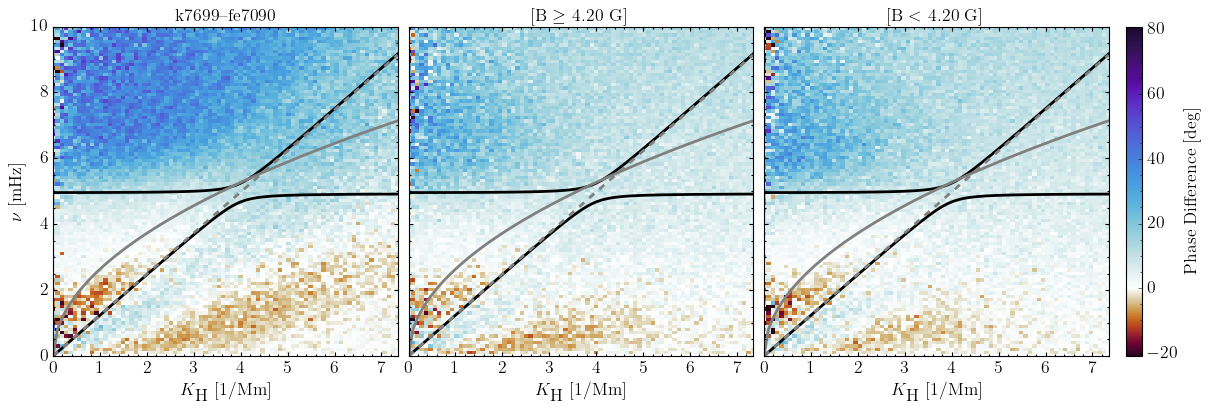

In [76]:

###############################################################################
#################################### Plot #####################################
###############################################################################

# Add in the time delay 
spectrum_magnetic = np.rad2deg(
    azim_phase_magnetic[:, :mid_time] + select_phase_correction[:, :mid_time]
)

spectrum_nonmagnetic = np.rad2deg(
    azim_phase_nonmagnetic[:, :mid_time] + select_phase_correction[:, :mid_time]
)

spectrum_orig = np.rad2deg(
    azim_phase_reg[:, :mid_time] + select_phase_correction[:, :mid_time]
)

vmin = -21  # -30
vmax = 81  # 51

cmap = cmr.fusion

color_fmode = "gray"
color_lamb = "gray"
color_regime = "k"


fig, axs = plt.subplots(
    1, 3, figsize=[15, 5], sharex=True, sharey=True, constrained_layout=True
)
# cs_nonmag = ax1.contour(ibnonmag[425, :, :], levels=[0, 4.09], colors="b")
# cs_mag = ax1.contour(ibmag[425, :, :], colors="r")

im2 = axs[0].pcolormesh(
    KH / convert_arcseconds_to_Mm,
    NU,
    spectrum_orig,
    cmap=cmap,
    shading="auto",
    norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
    rasterized=True,
)


axs[0].set_ylabel(r"$\nu$ [mHz]")

axs[0].set_title(spectral_line_higher + "--" + spectral_line_lower)


im3 = axs[1].pcolormesh(
    KH / convert_arcseconds_to_Mm,
    NU,
    spectrum_magnetic,
    cmap=cmap,
    shading="auto",
    norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
    rasterized=True,
)


axs[1].set_title(r"[B $\geq$ {:.2f} G]".format(chosen_mag_val))


im4 = axs[2].pcolormesh(
    KH / convert_arcseconds_to_Mm,
    NU,
    spectrum_nonmagnetic,
    cmap=cmap,
    shading="auto",
    norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax),
    rasterized=True,
)


# cbar = plt.colorbar(im4, ax=ax4)
cbar = fig.colorbar(im4, ax=axs[2], aspect=20)
cbar.ax.set_yscale("linear")
cbar.set_label(r"Phase Difference [deg]", fontsize=16)
axs[2].set_title(r"[B $<$ {:.2f} G]".format(chosen_mag_val))


# label customization
for ax in axs.flat:
    # ax.set_aspect(1)
    ax.minorticks_on()
    ax.xaxis.set_major_locator(mticker.AutoLocator())
    ax.yaxis.set_major_locator(mticker.AutoLocator())

    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator())

    ax.tick_params(axis="both", which="major", width=1)
    ax.tick_params(axis="both", which="minor", width=1)

    ax.set_xlim(0, (horizontal_array / convert_arcseconds_to_Mm).max())
    ax.set_ylim(0, 10)

    ax.set_xlabel(r"$K_{\textrm H}$ [1/Mm]")

    ax.plot(
        horizontal_array / convert_arcseconds_to_Mm,
        np.sqrt(qval1) * 1000 / (2 * np.pi),
        color=color_regime,
        linewidth=2.5,
    )
    ax.plot(
        horizontal_array / convert_arcseconds_to_Mm,
        np.sqrt(qval2) * 1000 / (2 * np.pi),
        color=color_regime,
        linewidth=2.5,
    )
    ax.plot(
        horizontal_array / convert_arcseconds_to_Mm,
        surface_fmode * 1000 / (2 * np.pi),
        color=color_fmode,
        linewidth=2.5,
    )
    ax.plot(
        horizontal_array / convert_arcseconds_to_Mm,
        lamb_curve * 1000 / (2 * np.pi),
        color=color_lamb,
        linewidth=2.5,
        linestyle="--",
    )

fig.set_constrained_layout_pads(wspace=-0.0001, hspace=-0.0001)

# fig.savefig("%s_%s_%s_masked_magnetic_field.png"%(spectral_line_higher,spectral_line_lower,fname_type), dpi=400, bbox_inches="tight")
plt.show()
